# Introduction

In industrial environments, especially at construction sites and factories where working conditions are hazardous and require a high level of safety, ensuring that workers comply with safety regulations is extremely important. One common safety requirement is that workers must wear a safety vest to reduce the risk of accidents.

This project focuses on an image classification task that detects whether a person in an image is wearing a safety vest. Successfully solving this problem can help organizations enhance workplace safety monitoring more efficiently through a deep learning model, instead of relying solely on manual inspection.

The project uses transfer learning by leveraging a pretrained model trained on a large dataset to recognize general visual features. We then fine-tune the model so it can distinguish between “wearing a safety vest” and “not wearing a safety vest” for our specific use case. The dataset used for training is sourced from Kaggle.

The goal of this project is to train an accurate classification model and evaluate its performance using a validation dataset. Finally, the model will be tested on images outside the training and validation sets to verify its ability to generalize rather than memorizing the training data.

## Load libraries

This code imports the necessary libraries for the project, including `fastai.vision.all` for computer vision tasks, `fastcore.all` for utility functions, `kagglehub` to interact with Kaggle datasets, `os` for operating system interactions, `matplotlib.pyplot` for plotting, and `seaborn` for enhanced data visualizations.

In [2]:
from fastai.vision.all import *
from fastcore.all import *
import kagglehub
import os
import matplotlib.pyplot as plt
import seaborn as sns

The output confirms that the libraries were imported successfully. This step is crucial for setting up the environment to load data, build and train the model, and visualize the results later in the notebook.

### Data Source Description

The dataset used in this project is the [Safety Vests Detection Dataset](https://www.kaggle.com/datasets/adilshamim8/safety-vests-detection-dataset), publicly available on Kaggle. This dataset contains images of individuals, labeled to indicate whether a person is wearing a safety vest or not. The dataset also includes bounding box annotations, which identify the regions of images containing people, enabling accurate extraction of relevant training samples.

There are two categories:
- vest (wearing a safety vest)
- not_vest (not wearing a safety vest)

The dataset provides separate folders for training, validation, and test images along with corresponding annotation files. These annotations include coordinates for bounding boxes and class labels, allowing us to prepare the data for fine-tuning a pretrained model using transfer learning.

In [3]:
path = kagglehub.dataset_download("adilshamim8/safety-vests-detection-dataset")

print("Path to dataset files:", path)

100%|██████████| 406M/406M [00:03<00:00, 139MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/adilshamim8/safety-vests-detection-dataset/versions/1


The output indicates that the dataset was successfully downloaded and its path is printed and the dataset might be available in a cached location, speeding up access. The printed path confirms where the dataset files are located, which is essential for accessing them in subsequent steps.

This code snippet uses the `get_image_files` function from FastAI to get a list of all image files within the specified training directory of the downloaded dataset.

In [6]:
file_names = get_image_files('/root/.cache/kagglehub/datasets/adilshamim8/safety-vests-detection-dataset/versions/1/train/train/')

This code loads a specific image file from the list of `file_names` (in this case, the 26th image, as list indexing starts from 0) using `PILImage.create`. It then resizes the image to a thumbnail size of 192 pixels while maintaining its aspect ratio and displays it.

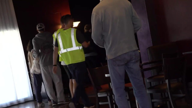

In [7]:
img = PILImage.create(file_names[25])

img.to_thumb(192)

The output displays a thumbnail representation of the loaded image with a size of 192 pixels on the longer side. This visually confirms that an image has been successfully loaded and can be displayed, allowing for a quick inspection of the data format.

This code defines a function `label` that takes a DataFrame as input and adds a new 'label' column based on the 'class' column, mapping 'Safety Vest' to 'vest' and 'NO-Safety Vest' to 'not_vest'. It then loads the annotation CSV files for the training, testing, and validation datasets into separate DataFrames (`df_train`, `df_test`, `df_valid`) and applies the `label` function to each DataFrame.

In [8]:
def label(df):
    df['label'] = df['class'].map({
        'Safety Vest': 'vest',
        'NO-Safety Vest': 'not_vest'
    })
df_train = pd.read_csv("/root/.cache/kagglehub/datasets/adilshamim8/safety-vests-detection-dataset/versions/1/train/train/_annotations.csv")
df_test = pd.read_csv("/root/.cache/kagglehub/datasets/adilshamim8/safety-vests-detection-dataset/versions/1/test/test/_annotations.csv")
df_valid = pd.read_csv("/root/.cache/kagglehub/datasets/adilshamim8/safety-vests-detection-dataset/versions/1/valid/valid/_annotations.csv")

label(df_train)
label(df_test)
label(df_valid)

This code has successfully loaded the annotation data into pandas DataFrames and added a 'label' column to each DataFrame based on the 'class' information. This structured data, containing filenames, bounding box coordinates, and the new 'label' (either 'vest' or 'not_vest'), is now ready for further processing and use in preparing the image data for training.

This code defines a function `save_data_crop` that takes a DataFrame and a type (e.g., 'train', 'test', 'valid') as input. It creates output directories for 'vest' and 'not_vest' classes within a 'processed' directory. It then iterates through each row of the input DataFrame, opens the corresponding image file, crops the image based on the bounding box coordinates provided in the DataFrame, and saves the cropped image to the appropriate class subdirectory within the 'processed' directory. Finally, it calls this function for the training, testing, and validation DataFrames to process and save the cropped images for each set.

In [9]:
DATA_ROOT = Path("/root/.cache/kagglehub/datasets/adilshamim8/safety-vests-detection-dataset/versions/1")
OUT_ROOT  = Path("./data/processed")

def save_data_crop(df, type):
  os.makedirs(f'{OUT_ROOT}/{type}/vest', exist_ok=True)
  os.makedirs(f'{OUT_ROOT}/{type}/not_vest', exist_ok=True)
  for _, row in df.iterrows():
    img_path = DATA_ROOT / type / type / row["filename"]
    out_dir  = OUT_ROOT / type / row["label"]
    with Image.open(img_path) as im:
      W, H = im.size

      x1, y1, x2, y2 = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])

      x1, y1 = max(0,x1), max(0,y1)
      x2, y2 = min(W,x2), min(H,y2)

      if x2 > x1 and y2 > y1:
        crop = im.crop((x1, y1, x2, y2))
        out_path = os.path.join(out_dir, f"{row['filename']}")
        crop.save(out_path, quality=92)

save_data_crop(df_train, 'train')
save_data_crop(df_test, 'test')
save_data_crop(df_valid, 'valid')

This code has successfully processed the images by cropping them based on the bounding box annotations and saving them into organized directories ('train', 'test', 'valid') with subdirectories for each class ('vest', 'not_vest'). This step is crucial for preparing the data in a format suitable for training the image classification model, ensuring that the model focuses on the relevant parts of the images.

This code sets up the data loaders for the image classification task using `ImageDataLoaders.from_folder` from FastAI. It specifies the path to the processed data, the training and validation folders, and applies image transformations. `Resize(384, pad_mode='zeros')` resizes images to 384 pixels, padding with zeros if necessary. `aug_transforms(size=224, max_warp=0.)` applies data augmentation techniques to images, resizing them to 224 pixels for the batch and limiting warping. `Normalize.from_stats(*imagenet_stats)` normalizes the image data using the mean and standard deviation from the ImageNet dataset, which is standard practice when using models pretrained on ImageNet. `bs=64` sets the batch size to 64.

In [10]:
path = './data/processed'

dls = ImageDataLoaders.from_folder(path,
                            train = 'train',
                            valid = 'valid',
                            item_tfms = Resize(384, pad_mode='zeros'),
                            batch_tfms=[*aug_transforms(size=224, max_warp=0.), Normalize.from_stats(*imagenet_stats)],
                            bs=64)

This code has successfully created `dls`, which is a FastAI `DataLoaders` object. This object efficiently handles loading and transforming the image data in batches for training and validation, incorporating resizing, data augmentation, and normalization as specified. It is now ready to be used for training the model.

This code displays a batch of images from the data loaders along with their corresponding labels using the `show_batch()` method. This provides a visual check to ensure that the data is loaded correctly and the labels are associated with the appropriate images after the data processing and loading steps.

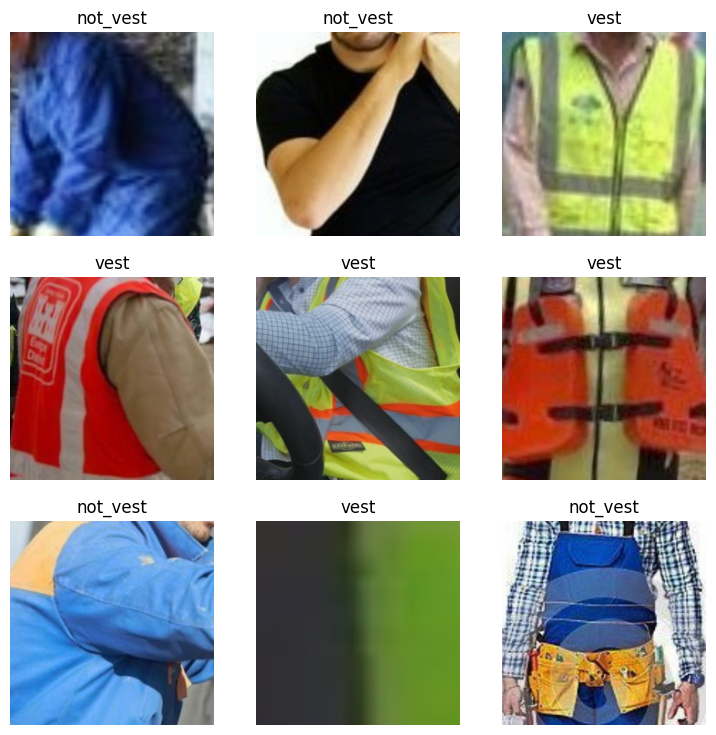

In [11]:
dls.show_batch()

The output displays a grid of images from a batch, each with its predicted label. This visual confirmation is important to verify that the data loading and labeling were successful, and that the images are being presented to the model correctly for training. The output indicates that the batch contains images with the labels 'not_vest' and 'vest'.

This code initializes a vision learner model using the `vision_learner` function from FastAI. It uses the created data loaders (`dls`), specifies the `resnet34` architecture as the pretrained model, and sets `error_rate` as the metric to evaluate the model's performance. `resnet34` is a common and effective convolutional neural network architecture for image classification tasks.

In [32]:
learn = vision_learner(dls, resnet34, metrics=error_rate)

This code has successfully initialized a FastAI `Learner` object named `learn`. This object encapsulates the `resnet34` model, the data loaders, and the specified metric. The model is now ready to be trained using the `fine_tune` method.

This code fine-tunes the pretrained `resnet34` model for 9 epochs using the `fine_tune` method. Fine-tuning involves training the model on the new dataset (safety vest images) to adapt its learned features to the specific task. The `epochs=5` parameter specifies that the training process will iterate over the entire dataset 9 times.

In [33]:
learn.fine_tune(epochs=9)

epoch,train_loss,valid_loss,error_rate,time
0,0.768679,0.411175,0.149123,00:21


epoch,train_loss,valid_loss,error_rate,time
0,0.408215,0.298701,0.093985,00:21
1,0.313582,0.201136,0.063910,00:20
2,0.221657,0.212494,0.055138,00:21
3,0.165439,0.198844,0.048872,00:20
4,0.112151,0.167573,0.043860,00:21
5,0.080749,0.137681,0.032581,00:21
6,0.060607,0.141353,0.032581,00:20
7,0.043545,0.142069,0.036341,00:20
8,0.039879,0.142034,0.036341,00:21


The output shows the training progress over the 9 epochs. For each epoch, it displays the training loss, validation loss, and the error rate on the validation set. Observing these metrics during training helps in understanding how well the model is learning and generalizing to unseen data. The decreasing loss values and error rate generally indicate that the model is improving.

This code creates a `ClassificationInterpretation` object from the trained `learn` object. This object provides tools to analyze the performance of a classification model. It then plots a confusion matrix using the `plot_confusion_matrix` method, with a specified figure size and DPI. The confusion matrix visually summarizes the performance of the classification model by showing the counts of true positive, true negative, false positive, and false negative predictions.

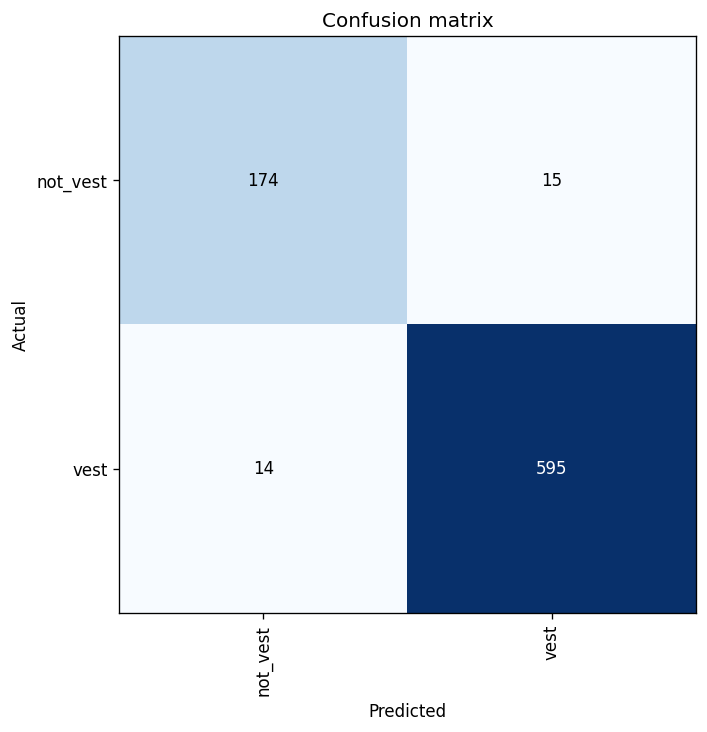

In [34]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6), dpi=120)

The output displays a confusion matrix. The rows represent the actual classes, and the columns represent the predicted classes. The numbers in the matrix indicate the count of images that fall into each category. This matrix is crucial for evaluating the model's performance, showing how many images were correctly classified and where the model made mistakes (e.g., predicting 'vest' when it was 'not_vest', or vice versa).

This code plots the images with the highest loss values using the `plot_top_losses` method of the `ClassificationInterpretation` object. It displays the top 20 images where the model was most uncertain or made the biggest errors in prediction, along with their predicted class, actual class, loss value, and probability of the predicted class. This visualization helps in identifying challenging examples or potential issues in the dataset that the model struggles with.

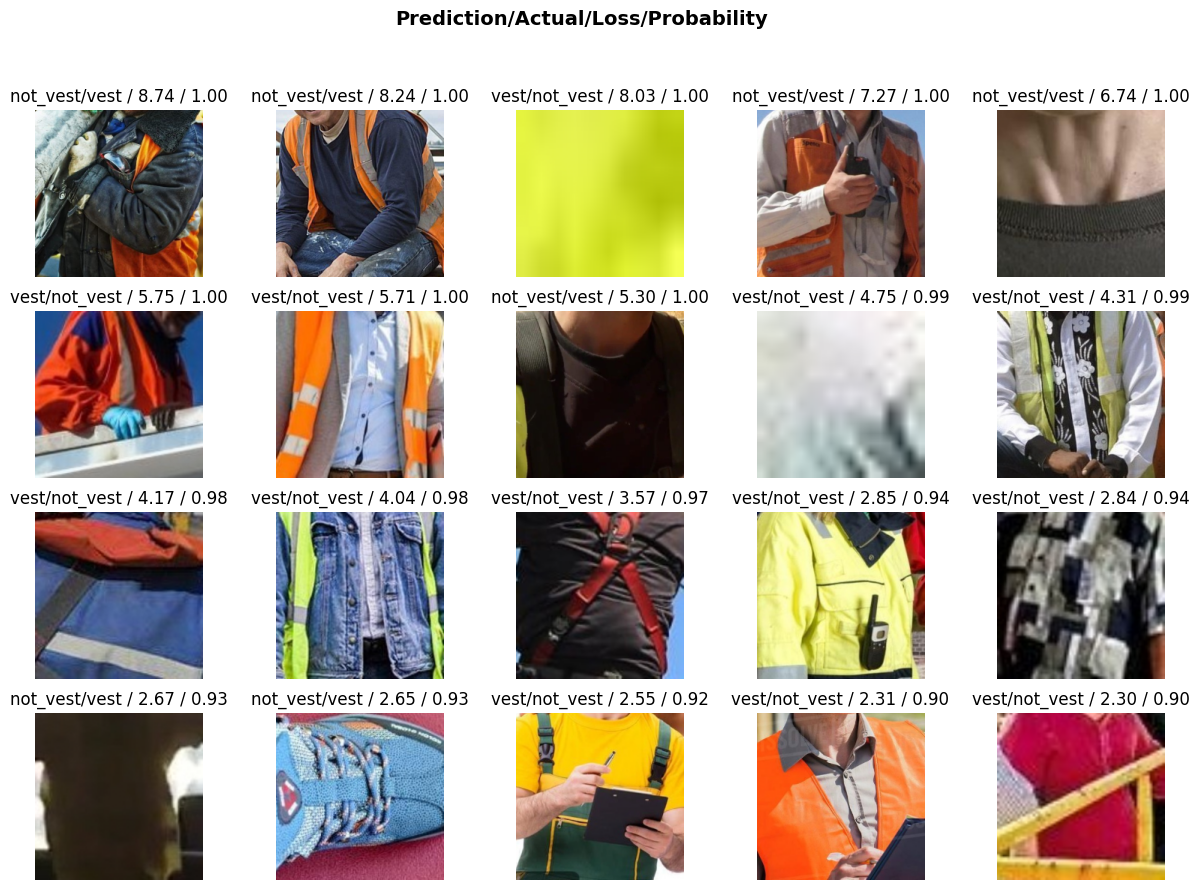

In [35]:
interp.plot_top_losses(20, figsize=(15,10))

The output displays a grid of the top 20 images with the highest loss. For each image, it shows the predicted label, the actual label, the loss value, and the probability assigned to the predicted label. This visualization is very useful for debugging and understanding the model's weaknesses by examining the types of images it misclassifies or is uncertain about. It can highlight issues like image quality, unusual examples, or mislabeling in the dataset.

### Analysis of Top Losses and Potential Dataset Issues

After examining the images with the highest loss values using `interp.plot_top_losses`, it was observed that some of these images appear to be incorrectly labeled. Mislabeled data in the training set can negatively impact the model's learning process and lead to decreased performance.

This finding suggests that data cleaning and verification could be a valuable next step to improve the dataset quality and potentially enhance the model's accuracy.

## Evaluation

This code downloads an image from a specified URL using the `wget` command and saves it as 'construction-vest.jpg'. It then creates a FastAI `PILImage` object from the downloaded image and displays a thumbnail of the image with a maximum size of 192 pixels. This step is for testing the trained model on a new, unseen image.

--2025-11-02 19:50:10--  https://www.qoreperformance.com/cdn/shop/files/construction-site_5052e205-8800-4e62-a0ea-d10e7e611709_1080x.jpg?v=1697655675
Resolving www.qoreperformance.com (www.qoreperformance.com)... 23.227.38.74, 2620:127:f00f:e::
Connecting to www.qoreperformance.com (www.qoreperformance.com)|23.227.38.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155913 (152K) [image/jpeg]
Saving to: ‘construction-vest.jpg’

construction-vest.j 100%[===================>] 152.26K  --.-KB/s    in 0.01s   

2025-11-02 19:50:10 (10.8 MB/s) - ‘construction-vest.jpg’ saved [155913/155913]



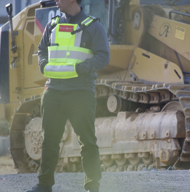

In [36]:
# Download the image
!wget https://www.qoreperformance.com/cdn/shop/files/construction-site_5052e205-8800-4e62-a0ea-d10e7e611709_1080x.jpg?v=1697655675 -O construction-vest.jpg

# create the image
img = PILImage.create('construction-vest.jpg')

# plot the image
img.to_thumb(192)

The output shows that the image was downloaded successfully and saved as 'construction-vest.jpg'. The second part is confirming that it was loaded correctly into a `PILImage` object and can be visualized.

This code uses the trained model (`learn`) to make a prediction on the downloaded image (`img`). It gets the predicted class, the index of the predicted class, and the probabilities for each class. It then creates a figure with two subplots. The first subplot displays the downloaded image with the predicted label as the title. The second subplot displays a horizontal bar plot showing the probability of the image belonging to each class ('vest' and 'not_vest'). This visualization helps to understand the model's prediction for the new image and the confidence level for each class.

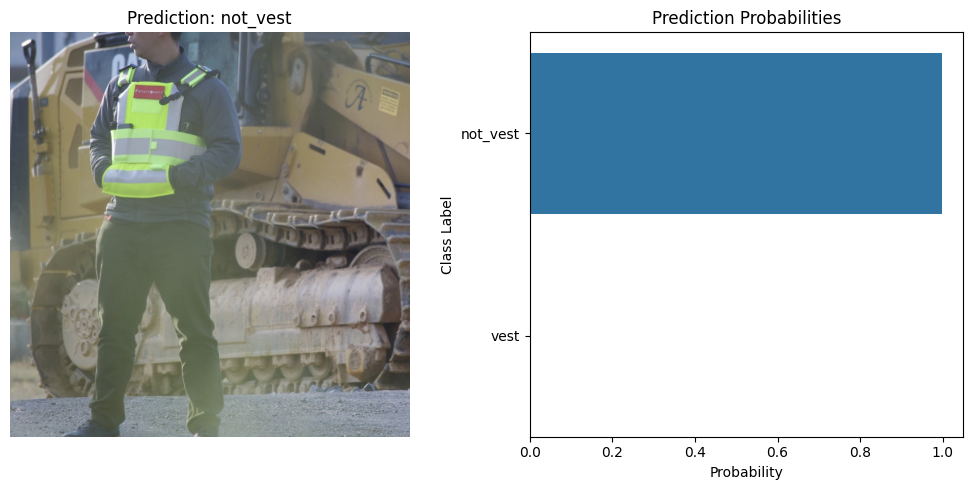

In [37]:
prediction, _, probs = learn.predict(img)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Display the image in the first subplot
axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title(f"Prediction: {prediction}")

# Display the bar plot in the second subplot
sns.barplot(x=probs, y=dls.vocab, orient='h', ax=axes[1])
axes[1].set_xlabel("Probability")
axes[1].set_ylabel("Class Label")
axes[1].set_title("Prediction Probabilities")

plt.tight_layout()
plt.show()

The output displays two plots side by side. This visualization clearly presents the model's prediction and the confidence scores, allowing for an assessment of how certain the model is about its prediction for the new image. In this case, we noted that the prediction was incorrect, indicating the model did not generalize well to this specific image that it suppose to recognize as vest.

### Discussion on Model Generalization and Dataset Size

The model incorrectly predicted the class of an external image downloaded from the internet, classifying a safety vest as 'not_vest'. This misprediction, especially after observing potential mislabeling in the training data, raises the possibility that the model may not be generalizing well to images outside of the training distribution.

One potential reason for this could be the size and diversity of the training dataset. If the dataset is not sufficiently large or representative of the types of images the model will encounter in real-world scenarios, the model may struggle to make accurate predictions on unseen examples. Increasing the size and diversity of the training data could potentially improve the model's ability to generalize.

### Evaluate using Test data set

This code evaluates the trained model's performance on the test dataset. It first counts the number of images in the 'test/vest' and 'test/not_vest' directories. Then, it iterates through each image in these directories, loads the image, and uses the trained model (`learn`) to predict the class. It keeps a count of how many images from each class are correctly predicted. Finally, it prints the total number of images in each test class, the number of correctly predicted images in each class, and the accuracy for each class. This provides a quantitative evaluation of the model's performance on unseen data from the test set.

In [38]:
test_vest_files = get_image_files('./data/processed/test/vest')
total_test_vest_files = len(test_vest_files)
print(f"Total test vest files: {total_test_vest_files}")
total_correct_vest = 0
test_not_vest_files = get_image_files('./data/processed/test/not_vest')
total_test_not_vest_files = len(test_not_vest_files)
print(f"Total test vest files: {total_test_not_vest_files}")
total_correct_not_vest = 0

for file in test_vest_files:
    img = PILImage.create(file)
    with learn.no_bar(), learn.no_logging():
        prediction,_,_ = learn.predict(img)
        if prediction == 'vest':
            total_correct_vest += 1
for file in test_not_vest_files:
    img = PILImage.create(file)
    with learn.no_bar(), learn.no_logging():
        prediction, _, _ = learn.predict(img)
        if prediction == 'not_vest':
            total_correct_not_vest += 1

print(f"Correctly predicted vest images: {total_correct_vest} out of {total_test_vest_files}. Accuracy: {total_correct_vest/total_test_vest_files:.2%}")
print(f"Correctly predicted not_vest images: {total_correct_not_vest} out of {total_test_not_vest_files}. Accuracy: {total_correct_not_vest/total_test_not_vest_files:.2%}")

Total test vest files: 300
Total test vest files: 108
Correctly predicted vest images: 295 out of 300. Accuracy: 98.33%
Correctly predicted not_vest images: 94 out of 108. Accuracy: 87.04%


The output provides a summary of the model's performance on the test set. The high accuracy values (98.33% for 'vest' and 87.04% for 'not_vest') indicate that the model performs well on the test data, which is a good sign of its ability to generalize to unseen examples from the same distribution as the training data.